<a href="https://colab.research.google.com/github/abdohamdyy/Object-Tracking-Count-Speed-Estemation-with-YOLOv10/blob/main/Object_Tracking_%26_Count_%26_Speed_Estemation_with_YOLOv10_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q supervision ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.5/825.5 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 10.1 MB/s eta 0:00:00


In [ ]:
import cv2
import time
import numpy as np
import supervision as sv
from ultralytics import YOLO

In [ ]:
Video_Path = '/content/sample_video.mp4'
target_video= '/content/target_video.mp4'
model_name= 'yolov10x.pt'
line1_y=400
line2_y=450
distance = 10
line1_times={}
line2_times={}
offset = 5

In [ ]:
model= YOLO(model_name)

100%|██████████| 61.4M/61.4M [00:00<00:00, 372MB/s]


In [ ]:
video_info = sv.VideoInfo.from_video_path(video_path=Video_Path)

In [ ]:
video_info

VideoInfo(width=1280, height=720, fps=30, total_frames=601)

In [ ]:
def calculate_speed(distance, time_taken):
    if time_taken == 0:
        return 0
    return distance / time_taken

In [ ]:
thickness = sv.calculate_optimal_line_thickness(resolution_wh=video_info.resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)

In [ ]:
byte_tracker= sv.ByteTrack(frame_rate=video_info.fps)

In [ ]:
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness )
label_annotator = sv.LabelAnnotator(text_thickness=thickness, text_scale=text_scale, text_position=sv.Position.BOTTOM_CENTER)
start, end = sv.Point(x=300,y=400), sv.Point(x=950,y= 400)
line = sv.LineZone(start=start, end=end)
line_annotator = sv.LineZoneAnnotator(thickness=thickness)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [ ]:
frame_generator = sv.get_video_frames_generator(source_path=Video_Path)


0: 384x640 1 car, 2 trucks, 48.4ms
Speed: 2.3ms preprocess, 48.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 3 trucks, 48.9ms
Speed: 2.3ms preprocess, 48.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 3 trucks, 47.8ms
Speed: 2.1ms preprocess, 47.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 2 trucks, 47.8ms
Speed: 1.8ms preprocess, 47.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 39.5ms
Speed: 1.6ms preprocess, 39.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 2 trucks, 31.3ms
Speed: 1.9ms preprocess, 31.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 1 truck, 31.0ms
Speed: 1.9ms preprocess, 31.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 30.6ms
Speed: 1.9ms preproce

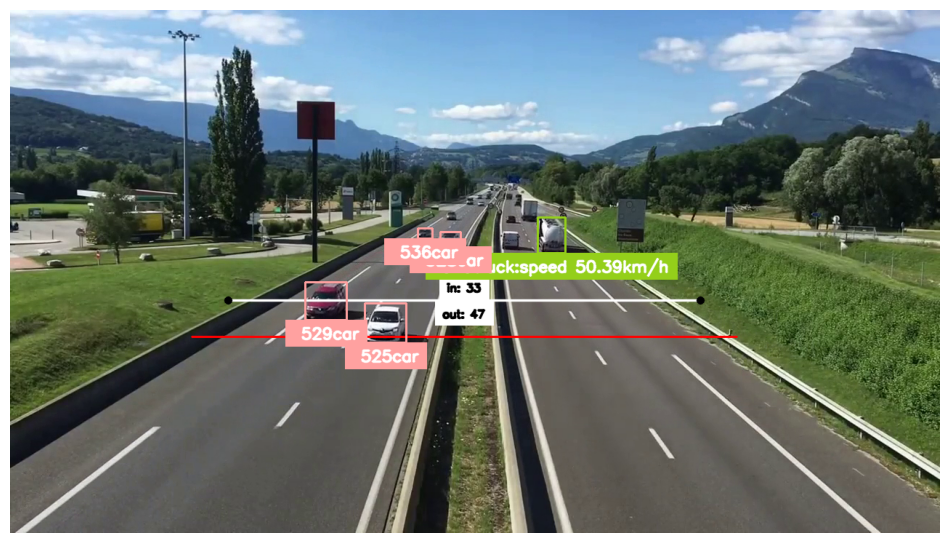

In [ ]:
with sv.VideoSink(target_video, video_info) as sink:
    for frame in frame_generator:
      results = model(frame)[0]
      detections = sv.Detections.from_ultralytics(results)
      detections= byte_tracker.update_with_detections(detections=detections)
      crossin,crossout = line.trigger(detections=detections)
      cv2.line(frame, (300, line1_y), (950, line1_y), (0, 255, 0), thickness=thickness)
      cv2.line(frame, (250, line2_y), (1000, line2_y), (0, 0, 255), thickness=thickness)
      labels =[]

      for i, tracker_id in enumerate(detections.tracker_id):
        if tracker_id is not None:
          box = detections.xyxy[i]
          center_y = int((box[1] + box[3]) / 2)
          class_name = detections.data['class_name'][i]
          label = f' {tracker_id}{class_name}'

          if line1_y - offset <=  center_y <= line1_y + offset:
            if tracker_id not in line1_times:
              line1_times[tracker_id] = time.time()
          if line2_y - offset <=  center_y <= line2_y + offset:
            if tracker_id not in line2_times:
              line2_times[tracker_id] = time.time()

          if tracker_id in line1_times and tracker_id in line2_times:
            time1 = line1_times[tracker_id]
            time2 = line2_times[tracker_id]
            time_tacken = abs(time2 - time1)
            speed =calculate_speed(distance, time_tacken)
            speed_kmh= speed * 3.6
            label += f':speed {speed_kmh:.2f}km/h'
          labels.append(label)


      annotated_frame = frame.copy()
      annotated_frame = line_annotator.annotate(frame= annotated_frame,line_counter= line)
      annotated_frame = bounding_box_annotator.annotate(scene = annotated_frame, detections = detections)
      annotated_frame = label_annotator.annotate(scene = annotated_frame, detections = detections, labels = labels)
      sink.write_frame(annotated_frame)
sv.plot_image(annotated_frame)